In [1]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import probability_mass_computation as proba
import plot_methods as plot

In [2]:
METHOD = 'polynomial'

h = 0.1

params = [h]

In [3]:
#Initial distribution
sigma = 0.05

mean_initial_state = [1, 1]
cov_initial_state = [[sigma, 0.0],
                     [0.0, sigma]]

#Noise structure
sigma_noise = 0.05

mean_noise = [0, 0]
cov_noise = [[sigma_noise, 0.0],
             [0.0, sigma_noise]]


#Steps ahead for prediction
n_steps_ahead = 6

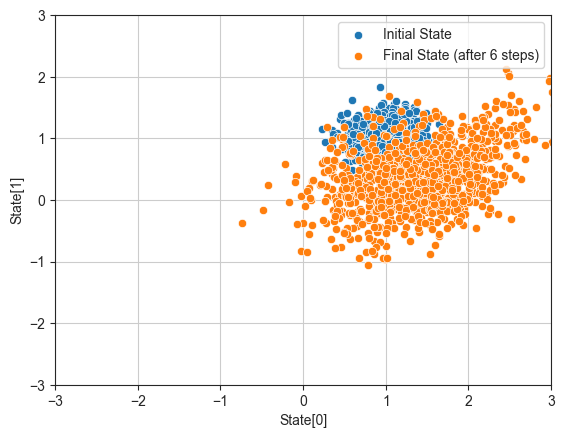

In [4]:
n_simulations = 1000
initial_states, final_states = propag.monteCarloSimulationSystem(n_simulations, mean_initial_state, cov_initial_state, mean_noise, cov_noise, n_steps_ahead, METHOD, params)
plot.plotSystemPropagation(initial_states, final_states, n_steps_ahead)

50
0.0493748197623758
48
0.07090197982408014
58
0.07105442066197118
71
0.06575384590259267
77
0.06809512020538265
90
0.06540923164298997


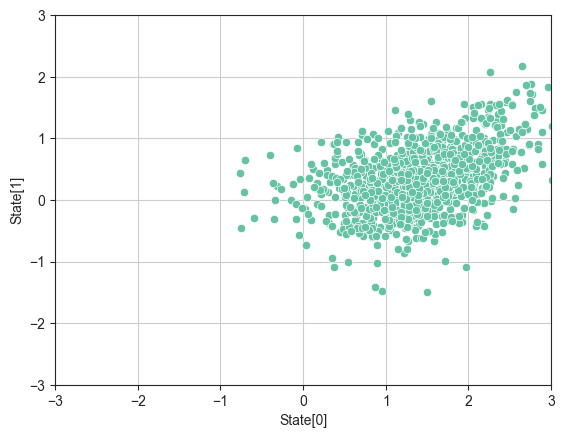

In [5]:
n_steps = range(n_steps_ahead-1) #There is a minus one because the sampleFromGmm already propagates the signatures for sampling, see equations

desired_region_size = 0.04

n_signatures = 50
print(n_signatures)

gmm = ([1.0], [mean_initial_state], cov_initial_state)

regions = grid.createRegions([mean_initial_state[0] - 4*cov_initial_state[0][0]**0.5, mean_initial_state[0] + 4*cov_initial_state[0][0]**0.5], [mean_initial_state[1] - 4*cov_initial_state[1][1]**0.5, mean_initial_state[1] + 4*cov_initial_state[1][1]**0.5], n_signatures)
signatures = grid.placeSignatures(regions, 0.5)
probas = proba.computeSignatureProbabilities(regions, [mean_initial_state], cov_initial_state, [1.0])

tv_bound = bounds.computeUpperBoundForTV(signatures, regions, gmm, cov_noise, METHOD, params)
print(tv_bound)

for step in n_steps:

    gmm = (probas, propag.propagateSignatures(signatures, METHOD, params), cov_noise)

    probas, signatures, regions = propag.propagateUncertaintyOneStep(desired_region_size, regions, signatures, probas, cov_noise, METHOD, params)

    tv_bound = bounds.computeUpperBoundForTV(signatures, regions, gmm, cov_noise, METHOD, params)
    print(tv_bound)


samples = propag.sampleFromGMM(1000, probas, signatures, cov_noise, METHOD, params)

plot.plotSamplesFromGMM(samples)